# Image Augmentation using TensorFlow
> A simple guide to perform image data augmentation using tensorflow.

- toc: true
- hide: false
- badges: true
- comments: true
- categories: [deeplearning, tensorflow2.x, data_augmentation, image]
- image: images/aug_image.png

In this tutorial we will explore the various ways one can perform image augmentation using TensorFlow. We will cover these following ways:

- Using tf.image and tfa.image .
- Using [Keras Preprocessing Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/).
- Using [Albumentations](https://github.com/albumentations-team/albumentations).


At each steps we will also explore the pros and cons of the all the above mentioned methods .

> Note: This tutorial doesn't cover model training or data preprocessing we will test our augmentations functions on the tf_flowers dataset available tensorflow_datasets. 

# Introduction

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. Data augmentation is a technique used for introducing variety in training data thereby helping to mitigate overfitting. 

With TensorFlow, we get a number of different ways we can apply data augmentation to image datasets. Here we will exploring the 3 different ways mentioned above.


Let’s get started!

## Experimental setup

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow_datasets as tfds

from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
import numpy as np
import math

tfa.register_all()
tf.random.set_seed(42)
np.random.seed(42)

autotune = tf.data.experimental.AUTOTUNE
print("Tensorflow Version          : ", tf.__version__)
print("Tensorflow Addons Version   : ", tfa.__version__)
print("Tensorflow Datasets Version : ", tfa.__version__)
print("Albumentations Version      : ", A.__version__)

Tensorflow Version          :  2.3.0
Tensorflow Addons Version   :  0.11.2
Tensorflow Datasets Version :  0.11.2
Albumentations Version      :  0.4.5


In [2]:
#hide
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We are going to use the `tf_flowers` dataset to demonstrate the experiments. Loading the Dataset into a `tf.data` format is done via just a single API call using `tensorflow_datasets` as given below :

In [22]:
#hide_output
#load in a sample dataset to perform image augmentation
ds_height = 120
ds_width  = 120
ds_batch  = 32

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True, split="train",)
class_names = info.features["label"].names
print(class_names)

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [23]:
#collapse_show
#Functions to display the images used in this experiment
def show_image_batch(images: list):
    """
    Displays a batch of image present in images
    """
    fig = plt.figure(figsize=(10,5))
    for idx in range(6):
        ax = plt.subplot(2, 3, idx+1)
        plt.imshow(images[idx])
        plt.axis("off")

def show_dataset(dataset):
    batch = next(iter(dataset))
    images, labels = batch
    
    plt.figure(figsize=(10, 10))
    for idx in range(9):
        ax = plt.subplot(3, 3, idx + 1)
        plt.imshow(images[idx].numpy().astype("uint8"))
        plt.title("Class: {}".format(class_names[labels[idx].numpy()]))
        plt.axis("off")

We will verify the images and the labels to ensure indeed parsed right . This will help in reducing error down the pipeline -

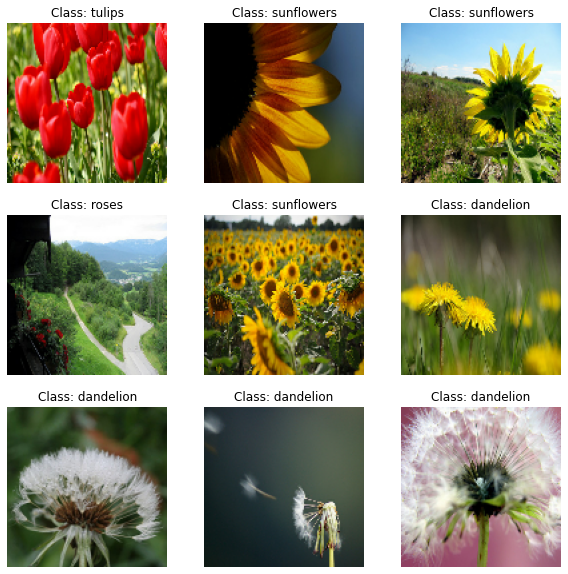

In [5]:
#collapse_show
#resize the images of the dataset to ensure all are of same shape
#because tensorflow expects all the batches in a dimension to be of same 
#shape
temp_ds = dataset.map(lambda x, y: (tf.image.resize(x, size=[ds_height, ds_width]), y))
show_dataset(temp_ds.batch(9))

Let's grab a random image . We will use this image to test our augmentation functions. At each step we will repeatedly apply the augmentation function to the same image and view the results.

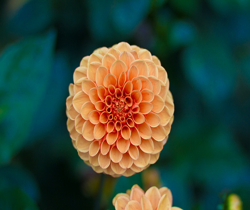

In [6]:
# grab a sample image to test image augmentations
h = 210
w = 250

image = load_sample_image("flower.jpg")
image = Image.fromarray(image)
image = image.resize(size=(w,h))
image

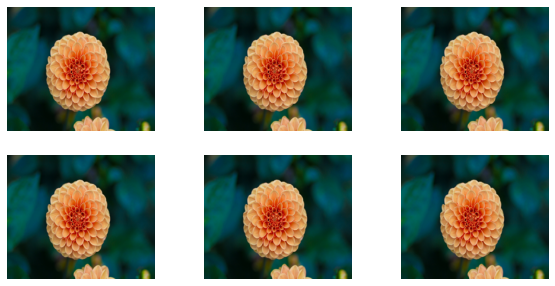

In [7]:
#hide
sample_batch = []
for _ in range(9):
    sample_batch.append(image)
show_image_batch(sample_batch)

Now that we have our random image and our tf_flowers dataset ready , let's procedd with creating our image augmentation pipelines -

# Using tf.image and tfa.image 

## Augmentation Functions

In this section we will create some augmentations functions using tensorflow to augment our image

In [8]:
def random_crop(image):
    """
    Randomly crops a given image
    """
    shape = tf.shape(image)
    dims_factor = tf.random.uniform([], 0.5, 1.0, dtype=tf.float32)
    height_dim  = tf.multiply(dims_factor, tf.cast(shape[0], tf.float32))
    width_dim   = tf.multiply(dims_factor, tf.cast(shape[1], tf.float32))
    image = tf.image.random_crop(image, [height_dim, width_dim, 3])
    return image

View augmentation results on the sample image - 

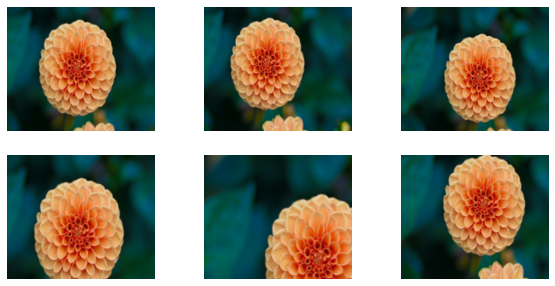

In [9]:
#collapse
def resize_sample_image(image):
    """
    Resizes the sample_image to dimesions [h,w,3]
    """
    return tf.image.resize(image, size=(h,w))


_batch = []
fn = random_crop

for _ in range(6):
    _im = fn(np.array(image))
    _im = resize_sample_image(_im)
    _batch.append(np.uint(_im))
show_image_batch(_batch)

In [10]:
def random_rotate90(image):
    """
    randomly rotates an image by a factor of 90 degree
    """
    rotate_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if rotate_prob > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    
    elif rotate_prob > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    
    elif rotate_prob > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
    return image

View augmentation results on the sample image -

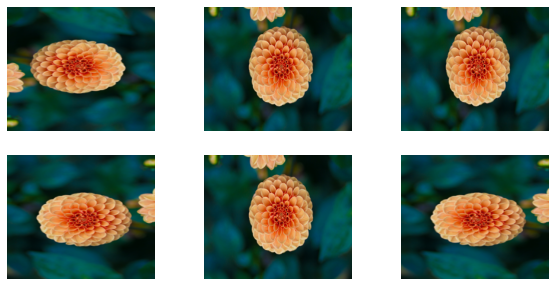

In [11]:
#collapse
_batch = []
fn = random_rotate90

for _ in range(6):
    _im = fn(np.array(image))
    _im = resize_sample_image(_im)
    _batch.append(np.uint(_im))
show_image_batch(_batch)

In [12]:
def random_rotate(image, angle=60):
    """
    Randomly rotates an image within the bounds (-angle, angle)
    """
    rotate_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    max_angle   = angle*math.pi/180
    rotation    = tf.random.uniform(shape=[], minval=-max_angle, maxval=max_angle, dtype=tf.float32)
    
    image = tfa.image.rotate(image, rotation, interpolation = "BILINEAR")
    image = tf.image.central_crop(image, central_fraction=0.8)
    return image

View augmentation results on the sample image -

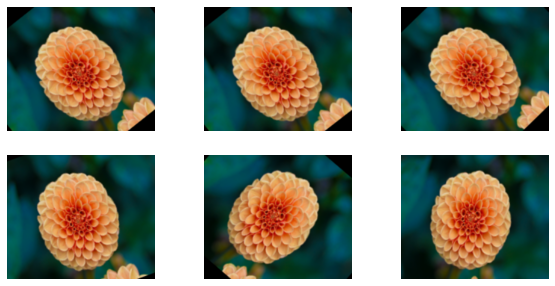

In [13]:
#collapse
_batch = []
fn = random_rotate

for _ in range(6):
    _im = fn(np.array(image))
    _im = resize_sample_image(_im)
    _batch.append(np.uint(_im))

show_image_batch(_batch)

In [14]:
def random_flip(image):
    """
    Randomly flips the given image along its dimensions. 
    The flip maybe horizontal or vertical.
    """
    flip_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if flip_prob > 0.75 :
        image = tf.image.transpose(image)
    
    elif flip_prob > 0.4:
        image = tf.image.random_flip_up_down(image)
    
    elif flip_prob > 0.3:
        image = tf.image.random_flip_left_right(image)
    return image

View augmentation results on the sample image -

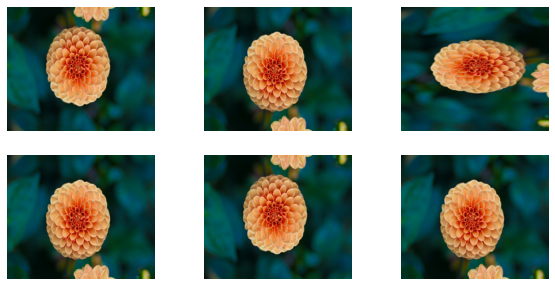

In [15]:
#collapse
_batch = []
fn = random_flip

for _ in range(6):
    _im = fn(np.array(image))
    _im = resize_sample_image(_im)
    _batch.append(np.uint(_im))
show_image_batch(_batch)

In [16]:
def random_lighting(image):
    """
    Applys random augmentations related to lighting
    """
    #apply random brightness
    image = tf.image.random_brightness(image, 0.2,)
    #apply random contrast
    image = tf.image.random_contrast(image, 0.6, 1.4,)
    #apply random hue
    image = tf.image.random_hue(image, 0.0)
    #apply random saturation
    image = tf.image.random_saturation(image, 0.5, 1.5,)
    return image

View augmentation results on the sample image -

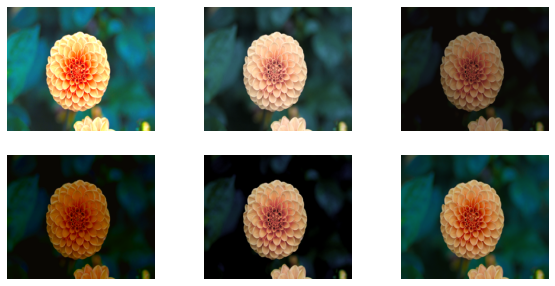

In [17]:
#collapse
_batch = []
fn = random_lighting

for _ in range(6):
    _im = fn(np.array(image))
    _im = resize_sample_image(_im)
    _batch.append(np.uint(_im))
show_image_batch(_batch)

## Putting it all together

We have seen the results of the above augmentation functions for a single image. In this part we well se how we can apply the image augmentations for a tensorflow dataset and create a image dataset for training on CNN using the `tf.data` API.

We will create a function that is going to randomly apply an image augmentation function for a given `(image, label)` pair from the original `tf.data.Dataset`. We will then `map` this function to the original dataset and then for each `(image, label)` pair of the original dataset the image augmentation functions should be applied. Let's see how this woul look like in code :

In [18]:
def apply_transformations(image, label):
    """
    Applys augmentations to a (image, label) pair.
    
    Args:
     image : a tensor image
     label : a tensor [label for the image]
     light : probability to apply random lighting to the image
     crop  : probability to apply random crops to the image
     flip  : probability to apply random flips to the image
     rot   : probability to apply random rotations to the image
     rot90 : probability to apply random 90 degree rotations to the image
    """
    light_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    crop_prob  = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    flip_prob  = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    rot_prob   = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    rot90_prob = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # apply random lightning
    if light_prob >= 0.5:
        image = random_lighting(image)
        
    # apply random crops
    if crop_prob >= 0.5:
        image = random_crop(image)      
    
    # apply random flips
    if flip_prob >= 0.5:
        image = random_flip(image)
    
    # apply random rotations
    if rot_prob >= 0.5:
        image = random_rotate(image)
    
    # apply random90 degree rotations
    if rot90_prob >= 0.5:
        image = random_rotate90(image)
        
    image = tf.image.resize(image, size=[ds_height, ds_width])
    image = tf.ensure_shape(image, shape=[ds_height, ds_width, 3])
    return image, label

Now, you would augment, augment, and batch our dataset :

In [19]:
aug_dataset = (
    dataset
    .map(apply_transformations, num_parallel_calls=autotune)
    .shuffle(1024)
    .batch(ds_batch)
    .prefetch(autotune)
    .cache()
)

Verifying if we constructed the data input pipeline correctly is a vital step before you feed your data to the model.

Let's view a few images from the dataset to ensure that the pipeline is working correctly :

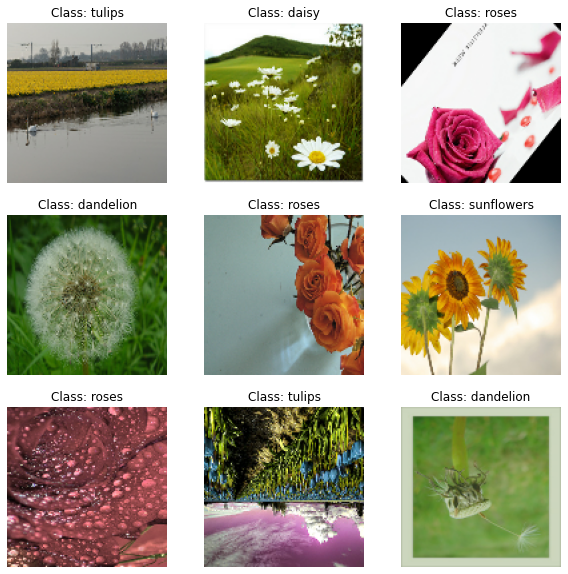

In [21]:
#collapse
show_dataset(aug_dataset)

To train a model on `aug_dataset` we can simply do the following :

```python
model = get_training_model(...) # func to get a model
model.fit(aug_ds, ...) # fit data on the model
```

## Pros & Cons

Using `TensorFlow image ops` with `tf.data` APIs provides a significant performance boost to our `image augmentation pipeline`. This option is by far the fastest way of generating a image augmentation piepeline in tensorflow. Another plus point is that since at each step we are using only TensorFlow Ops this makes this pipeline fully `TPU` compatible. We can run a model using this pipeline on the `TPU` without changing our `image augmentation pipeline`.

The downside to this performace boost is writing boilerplate code which makes the overall process more complex. TensorFlow image ops doesn't come with a lot of image augmentation functions as such many a times we will have to write complex functions for our suitable needs as show above.

> Tip: There are more image ops available with TensorFlow Addons which can found [here](https://www.tensorflow.org/addons/tutorials/image_ops).

# Using Keras Preprocessing Layers:

Tensorflow 2 introduced these [experimental preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) layers. Some these layers can be used for image augmentation.

There are two ways one can use these layers:
- Incorporate these layers directly into our model. With this option, data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration. Note that data augmentation is inactive at test time, so the input samples will only be augmented during `fit()`, not when calling `evaluate()` `or predict()`. This can be done like so - 
    ```python
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
    ...  # Rest of the model
    ```
    

- Apply it to the dataset, so as to obtain a dataset that yields batches of augmented images. With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model. This can be done like so -
    ```python
    aug_ds = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
    ```
    
    
For this experiment we will proceed using the 2nd option.

## Creating a data augmentation pipeline

First we will stack up the preprocessing layers and create a augmentation pipeline -

In [92]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip(),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.CenterCrop(ds_height, ds_width),
])

def resize_image(image, label):
    image = tf.image.resize(image, [ds_height, ds_width])
    return image, label

> Note: We can add more preprocessing layers to the `keras.Sequential` class. The full list of supported layers can be found [here](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/).

Let's test out the augmentation pipeline on the sample image we had above -

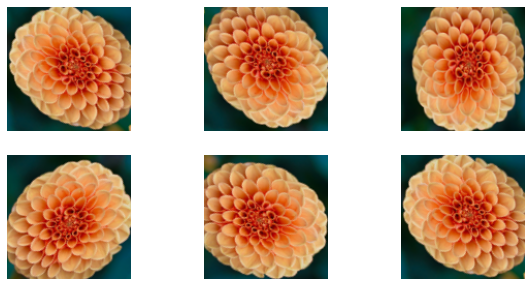

In [93]:
#collapse-show
_batch = []
fn = data_augmentation

for _ in range(6):
    _image = np.array(image)
    _image = np.expand_dims(_image, axis=0)
    _image = fn(_image, training=True)
    _batch.append(np.uint(_image[0]))
show_image_batch(_batch)

## Putting it all together

We have seen how the experimental preprocessing layers work for an single image and let's apply this augmentation for a full dataset. To do this we will use `lambda` function -

In [94]:
# hide_output
exp_layers_ds = (
    dataset
    .map(resize_image, num_parallel_calls=autotune)
    .batch(ds_batch)
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .shuffle(1024)
    .prefetch(autotune)
    .cache()
)

Cause: could not parse the source code:

    .map(lambda x, y: (data_augmentation(x, training=True), y))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

    .map(lambda x, y: (data_augmentation(x, training=True), y))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code:

    .map(lambda x, y: (data_augmentation(x, training=True), y))

This error may be avoided by creating the lambda in a standalone statement.

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


With this approach, we use `Dataset.map` to create a dataset that yields batches of augmented images. In the `data_augmentation` call we needed to set `training=True` because the layers will only work in training mode as explained above.

Let's view images from the augmented dataset -

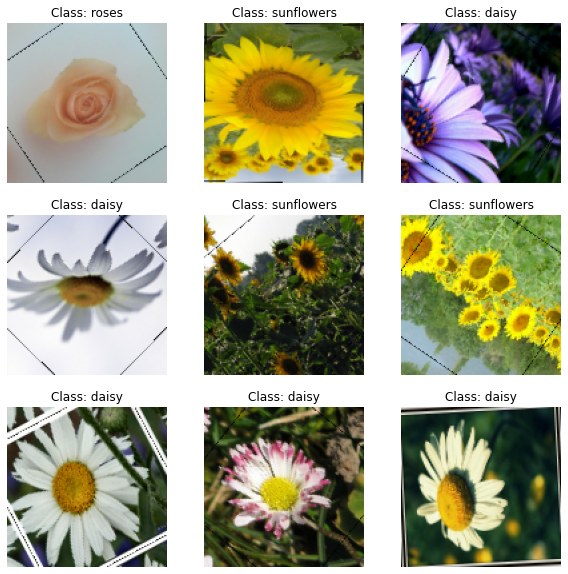

In [95]:
#collapse
show_dataset(exp_layers_ds)

Training a model on this dataset is same as traning a model on a `tf.data.Dataset` instance :
```python
model = get_training_model(...) # func to get a model
model.fit(exp_layers_ds, ...) # fit data on the model
```

## Pros & Cons

This method is a quite convenient way of performing image augmentation. `keras.layers.experimental.preprocessing` has many out-of-the-box convenient layers for image augmentation. The most valuable advantage of using this method is that if we use this layers as a part of the model then the augmentation can occur on the GPU, which makes training faster.

There are also a few problems with this method. Not all `keras.layers.experimental.preprocessing` layers are TPU compatible. using `keras.layers.experimental.preprocessing` in the model is faster but using these with the `tf.data` API's is slower as compared to using raw tensorflow image ops. Also , since this layers are still experimental there may be bugs.

> Tip: Example where these layers are directly incorporated into the model can be found [here](https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_preprocessing_layers).

# Using Albumentations

Finally we arrive at the last part of this tutorial. Here we will see how we can perform image aumentation using a 3rd party library like albumentations.

First we need to define a albumentations augmentation pipeline :

In [110]:
aug_pipeline = A.Compose([
    A.RandomBrightnessContrast(),
    A.RandomShadow(),
    A.HorizontalFlip(),
    A.CenterCrop(ds_height, ds_width),
    A.Rotate(limit=60),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.Resize(ds_height, ds_width),
])

> Note: For a list of all the augmentations offered by albumentations check their [docs](https://albumentations.ai/docs/).

Let's test the image augmentation piepeline on our sample image -

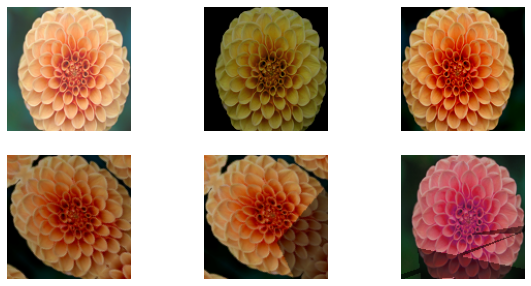

In [116]:
#collapse
_batch = []
fn = aug_pipeline

for _ in range(6):
    _image = np.array(image)
    _image = fn(image = _image)["image"]
    _batch.append(np.uint(_image))
show_image_batch(_batch)

## Putting it all together

To integrate albumentations with `tf.Data API's` we need to the do the following :
- warp the albumentations augmentation pipeline under `tf.numpy_function`.
- use `tf.ensure_shape` with the images to restore their shapes.

In [112]:
def albu_augments(image):
    image = aug_pipeline(image=image)["image"]
    image = tf.cast(image, tf.float32)
    return image


def apply_augments(image, label):
    image = tf.numpy_function(func=albu_augments, inp=[image], Tout=tf.float32)
    image = tf.ensure_shape(image, shape=[ds_height, ds_width, 3])
    return image, label

We use the `tf.ensure_shape` function to return shapes of the image when we apply the `tf.numpy_function`. We need to this because using `tf.numpy_function` makes the dataset lose its shape. Hence to return the shape of the dataset we need to use `tf.ensure_shape` or else the dataset will not be compatible with all the models of tensorflow.


We can now use `map`, `batch`, `shuffle`, `prefetch` to generate our dataset -

In [113]:
albu_ds = (
    dataset
    .map(apply_augments, num_parallel_calls=autotune)
    .batch(ds_batch)
    .shuffle(1024)
    .prefetch(autotune)
    .cache()
)

Let's check the dataset -

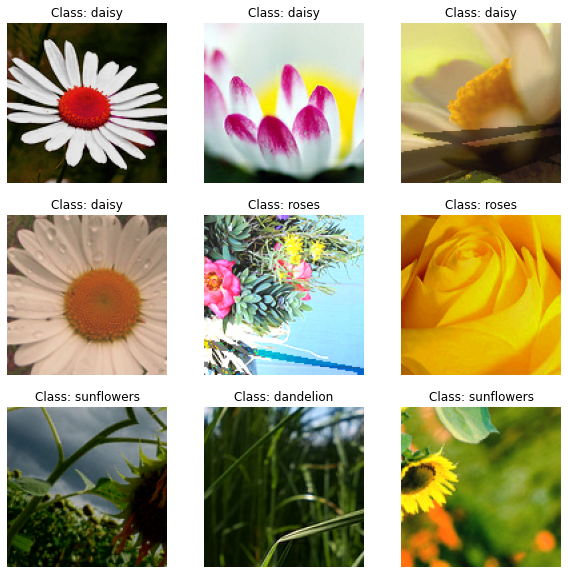

In [114]:
#collapse
show_dataset(albu_ds)

We can now use this augmented dataset to train our model :
```python
model = get_training_model(...) # func to get a model
model.fit(albu_ds, ...) # fit data on the model
```

## Pros and Cons

This method is very easy and flexible in the sense that `albumentations` provides a lot of good image augmentation functions. We do not need to write the boiler plate code of image augmentations.

The main disadvantages of this methods are :
- this method is the slower compared to the above 2 methods.
- since we use `tf.numpy_function` this piepeline is not TPU compatible.

# References

1. https://www.tensorflow.org/tutorials/images/data_augmentation
2. https://sayak.dev/tf.keras/data_augmentation/image/2020/05/10/augmemtation-recipes.html#Towards-more-complex-augmentation-pipelines
3. https://github.com/ageron/handson-ml2
4. https://keras.io/examples/vision/image_classification_from_scratch/
5. https://albumentations.ai/docs/
6. https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic